# One Vs All Classification

Based on logistic regression, we will use one-VS-all method to do multi-class classification.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
%matplotlib inline

## Explore the data
First, we load the data set which is also derived from Machine Learning By Stanford at Coursera.

In [52]:
data = sio.loadmat('ex3data1')#Note, this is a dictionary
X = data['X']
y = data['y']

In [53]:
print 'X Size', X.shape
print 'y Length', len(y)

X Size (5000, 400)
y Length 5000


There are 400 variables for each sample. Let's take a look at them.

In [54]:
y[:10]

array([[10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10]], dtype=uint8)

In [4]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

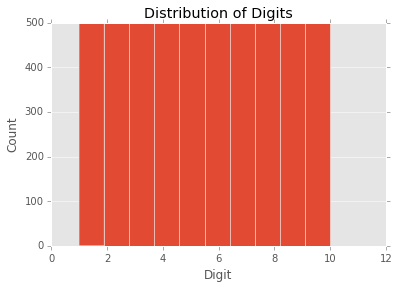

In [5]:
plt.style.use('ggplot')
plt.hist(y)
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Distribution of Digits')

It seems the digits are balanced. There are 10 digits(1-10) in total, each should be treated as a class. And we can display the input data as well. According to the instruction, '10' is mapped into '0'. Note, each item of y is stored in an *numpy* array, we need to transform them to numeric.

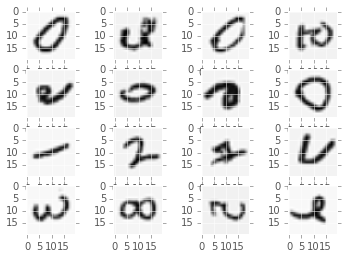

In [6]:
#Transform the original 1D data into 2D data 
def imageTransform(x):
    m = len(x)
    display_rows = int(np.sqrt(m))
    display_cols = int(m / display_rows)
    image = np.zeros([display_rows, display_cols])
    for i in range(display_rows):
        start = display_cols * i
        end = display_cols * (i + 1)
        image[i, :] = x[start:end]
    return image
#Display the input data as images
index = np.random.choice(len(X), 16)
for i in range(len(index)):
    plt.subplot(4, 4, i+1)
    image = imageTransform(X[index[i]])
    plt.imshow(image, cmap=plt.cm.gray_r)

Those are handwritten digits with certain distortions, rotations. In order to dao training and testing, we need to split the original data set into two parts. Before splitting, we transform y to a vector, then we shuffle the data set and split randomly.

In [55]:
#Shuffle the data and split at random
y[y==10] = 0#Map 10 into 0
#Transform y into arrays of integers directly
y = y.flatten()
np.random.seed(111)
index_shuffle = np.random.permutation(len(y))
training_num = int(len(y) * 0.8)
X_train = X[index_shuffle[:training_num]]
y_train = y[index_shuffle[:training_num]]
X_test = X[index_shuffle[training_num:]]
y_test = y[index_shuffle[training_num:]]

## Logistic Regression

Like what we did in logistic regression part, here we need to define *sigmoid*, *addOnes*, *accuracy* functions and etc. For the multi-class problems, we can make some changes.

In [56]:
#Define sigmoid function
def sigmoid(Z):
    return 1/(1 + np.exp(-Z))

Note, we need to add biases for each classifier, consequently an extra column of ones are necessary.

In [57]:
#Add oncstants to the original input
#Create theta with theta0
def addOnes(X):
    if X is None:
        print 'Input Null!'
        return None, None
    dim = X.shape
    #If X has multi variables
    if dim>1:
        feature_num = X.shape[1]
        X = np.insert(X, feature_num, 1, axis=1)
        theta = np.zeros(feature_num+1)
        return X, theta
    #If X only has one variable
    else:
        temp_X = np.ones([len(X), 2])
        temp_X[:, 0] = X
        theta = np.zeros(2)
        return temp_X, theta

In [79]:
#Calculate the accuracy
def accuracy(y, y_test):
    '''Calculate Accuracy'''
    return np.mean(y==y_test)

We choose the classifier which has the largest probability as the prediction, for example, if the fifth classifier has the largest probability, then we will set the prediction as 5.

In [1]:
#Create a function to do predictions
def modelPredict(test, theta):
    '''Make predictions'''
    if len(test.shape) < 2:
        print 'The input has too few dimensions'
        return None
    feature_num = test.shape[1]
    sample_num = len(test)
    #Add constants
    test = np.insert(test, feature_num, 1, axis=1)
    H = np.dot(test, theta)
    Z = sigmoid(H) 
    #Select the class which has largest probability
    predictions = [z.argmax() for z in Z]
    return predictions

A common cross entropy cost funtion is introduced as well as regularization.

In [58]:
#Define cost function, X stands for input matrix
#y stands for the labels
#lambda1 stands for the regularization coefficient
def costFuncWithReg(X, y, theta, lambda1=0.01):
    '''Calculate the errors of logistic regression'''
    ###############Deal with unusual inputs###########
    if X is None or y is None:
        print 'Empty Input For Cost!'
        return None
    if len(X.shape) == 1 and len(theta) !=1 :
        print 'The input dimensions do not match!'
        return None
    if len(X) != len(y) or X.shape[1] != len(theta):
        print 'The theta dimensions do not match!'
        return None
    ##############Calculate Output####################
    sample_num = len(y)#Length of y
    feature_num = len(theta)
    H = np.dot(X, theta)#Product of X and theta
    #print H
    Z = sigmoid(H)# Sigmoid Output
    #print Z
    ##############Calculate the Cost##################
    #Split the data into two parts, y=1, y=0
    y_1 = y[y==1]
    y_0 = y[y==0]    
    Z_1 = Z[y==1]
    Z_0 = Z[y==0]
    total = -np.dot(y_1, np.log(Z_1)) - np.dot(1-y_0, np.log(1-Z_0))
    if sample_num>0:
        total = total/sample_num
    else:
        print 'Invalid Input!'
        return None
    #############Add regularization###################
    #Note, theta0 is not considered
    total += lambda1 * sum(np.square(theta[:feature_num]))/2/sample_num
    return total     

Below there is a binary classifier. One Vs All means we make classification for each class.

In [59]:
#Update theta values
def trainLogisticRegressionWithReg(X, y, alpha=0.01, lambda1=0.01, num_iters=30):
    '''Update theta values'''
    #Deal with extreme cases
    if X is None or y is None:
        return None
    if len(X) != len(y):
        print 'The dimensions do not match!'
        return None 
    
    #Define some variables
    [X_new, theta] = addOnes(X)#Add ones to X
    sample_num = len(y)#the length of the samples
    feature_num = len(theta)#the number of features
    cost_iter = np.zeros(num_iters)#Record the cost each time
    #Iteration
    for i in range(num_iters):
        #Update theta during each iteration
        diff = sigmoid(np.dot(X_new, theta)) - y
        grad = np.dot(diff, X_new)/sample_num
        #print len(grad)
        grad[:feature_num] += lambda1 * theta[:feature_num]/sample_num
        theta = theta - alpha * grad        
        cost_iter[i] = costFuncWithReg(X_new, y, theta, lambda1)
    
    return theta, cost_iter

In [70]:
#Define some variables
digit_num = 10#Digit number
sample_num = len(y)#Sample numbers
feature_num = X.shape[1]#Sample features
Thetas = np.zeros([feature_num+1, digit_num])#theta for each class

One Vs All means we need to find a binary classifier for each class, to check whether a sample belongs to this specific class or not. If there are two classes, then we need 10 classifiers. In order to prevent against overfitting, we use regularization here.

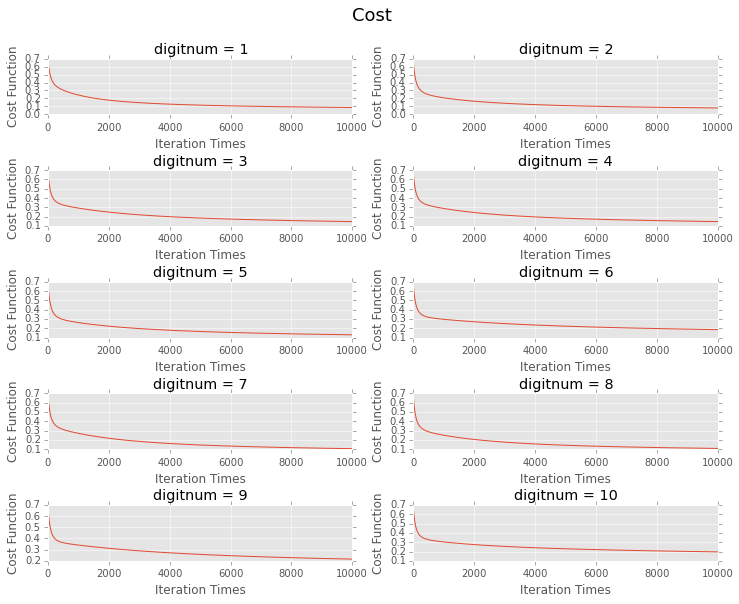

In [101]:
#Train a model for each class
fig = plt.figure(figsize=(12, 9))
for i in range(digit_num):
    y_digit = y_train== i
    y_digit = y_digit * 1
    theta, costs = trainLogisticRegressionWithReg(X=X_train, y=y_digit, alpha=0.0015, lambda1=0.001, num_iters=10000)  
    Thetas[:, i] = theta
    ax = fig.add_subplot(5, 2, i+1)
    ax.plot(costs)
    ax.set_title('digitnum = %s'%(i+1))
    ax.set_xlabel('Iteration Times')
    ax.set_ylabel('Cost Function')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=None, hspace=1)
fig.suptitle('Cost', fontsize=18)

Let's check the performance on training and testing data set.

In [102]:
preds = modelPredict(X_train, Thetas)

In [103]:
accuracy(preds, y_train)

0.85550000000000004

In [104]:
preds = modelPredict(X_test, Thetas)
accuracy(preds, y_test)

0.84799999999999998

The accuracy is not satisifying, if we increase iteration times or tune alpha, perhaps it will go up. Or we can try other methods, such as neural network, we will discuss that in next part.